<a href="https://colab.research.google.com/github/Khaled-Mohammed-Abdelgaber/DR-mostafa/blob/main/master_ECG_generation_from_PPG_using_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sequence of project:
* first cluster datasets
* study the effect of adding LSTM in encoder and decoder
* we will do the following once using Conv1D and once using Conv2D 
* train a traditional autoencoder for each cluster 
* train a variational autoencoder for each cluster 
* comapare results

#Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#to read csv files
import pandas as pd 

#to manipulate data
import numpy as np

#for ploting
import matplotlib.pyplot as plt
import seaborn as sns

#for PCA
from sklearn.decomposition import PCA

#for Kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#to shuffle datasets
from sklearn.utils import shuffle

#for autoencoder design
import keras
import tensorflow as tf
from keras.layers import *
from keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from keras.engine.sequential import Sequential

#Loading Datasets


In [ ]:
ppg1 = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/10_beat_signals/part_1_PPG_signals_10_beats_Aug_2022.csv",
                           names = np.arange(1024))

ppg2 = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_2/10_beat_signals/part_2_PPG_signals_10_beats_Aug_2022.csv",
                            names = np.arange(1024))

ecg1 = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_1/10_beat_signals/part_1_ECG_signals_10_beats_Aug_2022.csv",names = np.arange(1024))
ecg2 = pd.read_csv("/content/gdrive/MyDrive/data/peak2peak_aug_2022/Part_2/10_beat_signals/part_2_ECG_signals_10_beats_Aug_2022.csv",names = np.arange(1024))


In [ ]:
PPG = pd.concat([ppg1 , ppg2],ignore_index=True)
ECG = pd.concat([ecg1 , ecg2],ignore_index=True)

In [ ]:
PPG

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.93827,0.93797,0.93668,0.93271,0.92657,0.91835,0.90804,0.89557,0.88077,0.86366,...,0.83921,0.87134,0.89890,0.92160,0.93962,0.95299,0.96284,0.96939,0.97306,0.97468
1,0.97918,0.97711,0.97282,0.96595,0.95673,0.94525,0.93125,0.91482,0.89634,0.87574,...,0.81925,0.85823,0.89068,0.91687,0.93754,0.95296,0.96399,0.97080,0.97323,0.97392
2,0.91117,0.91058,0.90876,0.90415,0.89734,0.88842,0.87828,0.86690,0.85514,0.83849,...,0.77387,0.81272,0.84544,0.87188,0.89287,0.90876,0.92067,0.92875,0.93312,0.93501
3,0.94427,0.94437,0.94375,0.94039,0.93489,0.92729,0.91784,0.90638,0.89254,0.87656,...,0.69776,0.74174,0.77864,0.80684,0.82829,0.84364,0.85592,0.86501,0.87067,0.87340
4,0.88354,0.88384,0.88364,0.88063,0.87566,0.86903,0.86046,0.84995,0.83731,0.82326,...,0.76663,0.80782,0.84318,0.87221,0.89548,0.91317,0.92619,0.93491,0.93986,0.94210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30903,0.78430,0.78038,0.76978,0.75210,0.72821,0.69945,0.66660,0.62988,0.59348,0.55708,...,0.45599,0.50426,0.55991,0.61714,0.67085,0.71842,0.75730,0.78631,0.80565,0.81533
30904,0.90737,0.90385,0.89257,0.87655,0.85532,0.82831,0.79768,0.76319,0.72758,0.69055,...,0.46153,0.51371,0.57062,0.62438,0.67618,0.71994,0.75459,0.77971,0.79390,0.79709
30905,0.76031,0.75323,0.74221,0.72365,0.69896,0.67104,0.64018,0.60524,0.56914,0.53142,...,0.62764,0.69218,0.74851,0.80043,0.85420,0.90306,0.94429,0.97471,0.99189,1.00000
30906,0.81240,0.80645,0.79196,0.76904,0.74286,0.71647,0.68736,0.65579,0.62166,0.58599,...,0.52504,0.57507,0.62821,0.67995,0.72699,0.76694,0.79972,0.82323,0.83589,0.84050


In [ ]:
ECG.describe()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,...,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000,30908.000000
mean,0.954098,0.767797,0.513173,0.305306,0.193510,0.141974,0.127209,0.126940,0.129828,0.132433,...,0.193051,0.189841,0.186843,0.188250,0.204228,0.257521,0.377335,0.588700,0.828897,0.953061
std,0.043030,0.176620,0.265105,0.256846,0.200464,0.157618,0.146036,0.147300,0.151374,0.154040,...,0.148567,0.153823,0.162520,0.171859,0.177046,0.184192,0.202291,0.201535,0.123134,0.038762
min,0.511190,0.106990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.611070
25%,0.942710,0.648580,0.299830,0.100440,0.055090,0.047659,0.040289,0.032262,0.028605,0.028575,...,0.096748,0.090362,0.082983,0.080271,0.089493,0.121090,0.221770,0.445180,0.768290,0.938860
50%,0.962795,0.794870,0.485950,0.238560,0.137750,0.100620,0.084449,0.078873,0.073769,0.071335,...,0.132475,0.127115,0.123580,0.123100,0.144235,0.216785,0.358345,0.607185,0.855485,0.961950
75%,0.980100,0.926710,0.720390,0.438150,0.252750,0.172220,0.158780,0.163340,0.170610,0.177510,...,0.249330,0.249170,0.249450,0.251530,0.265190,0.342410,0.507740,0.740050,0.918410,0.977960
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.996980,0.993510,0.989600,0.985530,...,0.985800,0.987690,0.989760,0.991810,0.991710,0.992300,0.994430,1.000000,1.000000,1.000000


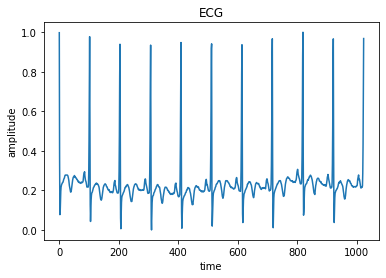

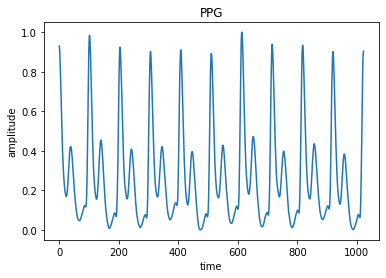

In [ ]:
idx = np.random.randint(0,PPG.shape[0])
plt.plot(ECG.iloc[idx,:].values);
plt.xlabel('time');
plt.ylabel('amplitude');
plt.title("ECG");

plt.figure();
plt.plot(PPG.iloc[idx,:].values);
plt.xlabel('time');
plt.ylabel('amplitude');
plt.title("PPG");

In [ ]:
#will make data frame to store indexes and clusters numbers of datasets as will we see later
df_info = pd.DataFrame(data = np.arange(0,PPG.shape[0]),columns=['index']) 
df_info

,index
0,0
1,1
2,2
3,3
4,4
...,...
30903,30903
30904,30904
30905,30905
30906,30906


#PCA components and clustering

##finding pca components for ppg

In [ ]:
pca = PCA(n_components=3)
ppg_pca_values = pca.fit_transform(PPG.values)
print("PCA variance is ",pca.explained_variance_ratio_)
df_info["ppg_pca1"] = ppg_pca_values[:,0]
df_info["ppg_pca2"] = ppg_pca_values[:,1]
df_info["ppg_pca3"] = ppg_pca_values[:,2]

PCA variance is  [0.25641105 0.19930359 0.12968334]


#getting ride of outliers

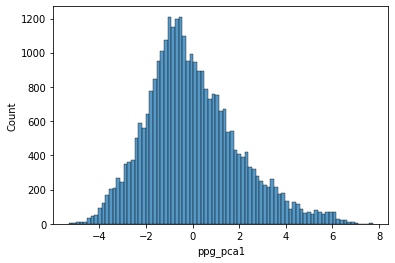

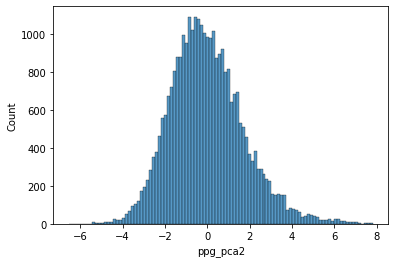

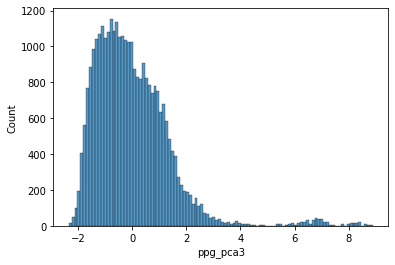

In [ ]:
sns.histplot(df_info['ppg_pca1'])
plt.figure()
sns.histplot(df_info['ppg_pca2'])
plt.figure()
sns.histplot(df_info['ppg_pca3'])

In [ ]:
PPG.shape

(30908, 1024)

In [ ]:
ECG.shape

(30908, 1024)

In [ ]:
30908 - 1462-610

28836

In [ ]:
df_info = df_info.reset_index(drop = True)
ECG = ECG.reset_index(drop = True)
PPG = PPG.reset_index(drop = True)
pca1_outliers_idx = np.where((df_info['ppg_pca1'].values > 4) | (df_info['ppg_pca1'].values < -4))[0]
print("numbers of outliers are equal to ",pca1_outliers_idx.shape)

numbers of outliers are equal to  (1462,)


In [ ]:
for i in pca1_outliers_idx:
  try:
    PPG.drop(i,axis = 0,inplace = True)
  except KeyError:
    print(i ," not found in ppg")
    continue

for i in pca1_outliers_idx:
  try:
    df_info.drop(i,axis = 0,inplace = True)

  except KeyError:
    print(i ," not found in df_info")
    continue


for i in pca1_outliers_idx:
  try:
    ECG.drop(i,axis = 0,inplace = True)
  except KeyError:
    print(i ," not found in ECG")
    continue

In [ ]:
df_info = df_info.reset_index(drop = True)
ECG = ECG.reset_index(drop = True)
PPG = PPG.reset_index(drop = True)
pca2_outliers_idx = np.where((df_info['ppg_pca2'].values > 3.5) & (df_info['ppg_pca2'].values < -3.5))[0]
print("numbers of outliers are equal to ",pca2_outliers_idx.shape)

numbers of outliers are equal to  (0,)


In [ ]:
for i in pca2_outliers_idx:
  try:
    PPG.drop(i,axis = 0,inplace = True)
  except KeyError:
    print(i ," not found in ppg")
    continue

for i in pca2_outliers_idx:
  try:
    df_info.drop(i,axis = 0,inplace = True)

  except KeyError:
    print(i ," not found in df_info")
    continue


for i in pca2_outliers_idx:
  try:
    ECG.drop(i,axis = 0,inplace = True)
  except KeyError:
    print(i ," not found in ECG")
    continue

In [ ]:
df_info = df_info.reset_index(drop = True)
ECG = ECG.reset_index(drop = True)
PPG = PPG.reset_index(drop = True)
pca3_outliers_idx = np.where((df_info['ppg_pca3'].values > 2.5))[0]
print("numbers of outliers are equal to ",pca3_outliers_idx.shape)

numbers of outliers are equal to  (610,)


In [ ]:
for i in pca3_outliers_idx:
  try:
    PPG.drop(i,axis = 0,inplace = True)
  except KeyError:
    print(i ," not found in ppg")
    continue

for i in pca3_outliers_idx:
  try:
    df_info.drop(i,axis = 0,inplace = True)

  except KeyError:
    print(i ," not found in df_info")
    continue


for i in pca3_outliers_idx:
  try:
    ECG.drop(i,axis = 0,inplace = True)
  except KeyError:
    print(i ," not found in ECG")
    continue

In [ ]:
ECG.describe()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,...,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000
mean,0.954445,0.768046,0.512362,0.304441,0.192487,0.140307,0.125425,0.125283,0.128402,0.131088,...,0.191721,0.187353,0.182804,0.182667,0.198019,0.251564,0.372254,0.585216,0.828260,0.953588
std,0.042797,0.177190,0.266267,0.258920,0.201121,0.156694,0.144581,0.145721,0.149979,0.152683,...,0.146675,0.151318,0.158061,0.164407,0.168367,0.176772,0.198687,0.201257,0.123505,0.038214
min,0.511190,0.106990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.611070
25%,0.943400,0.647830,0.297310,0.098360,0.053459,0.046273,0.039907,0.031848,0.028151,0.027964,...,0.096715,0.090191,0.082866,0.080045,0.089256,0.120160,0.219930,0.440590,0.766770,0.939520
50%,0.962925,0.796150,0.485365,0.236150,0.136130,0.099388,0.083216,0.077649,0.072597,0.069652,...,0.131115,0.125405,0.122025,0.120850,0.141895,0.213780,0.354140,0.603555,0.855275,0.962160
75%,0.980180,0.927900,0.721720,0.439260,0.249850,0.169720,0.155090,0.159310,0.167070,0.175070,...,0.247110,0.245020,0.244020,0.245620,0.257370,0.335460,0.502640,0.736320,0.918100,0.978050
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984460,0.976680,0.972370,0.956940,...,0.957510,0.962200,0.972600,0.979410,0.984620,0.986910,0.992670,1.000000,1.000000,1.000000


In [ ]:
print("PPG dataframe shape is ",PPG.shape)
X = shuffle(PPG).values
print("PPG numpy array shape is ",X.shape)

print("ECG dataframe shape is ",ECG.shape)
y = shuffle(ECG).values
print("y numpy array shape is ",y.shape)


PPG dataframe shape is  (28836, 1024)
PPG numpy array shape is  (28836, 1024)
ECG dataframe shape is  (28836, 1024)
y numpy array shape is  (28836, 1024)


In [ ]:
df_info.head()

,index,ppg_pca1,ppg_pca2,ppg_pca3
0,0,-0.963906,2.011657,-0.862863
1,1,0.120343,0.957556,-1.310513
2,2,1.270500,1.880604,-0.543196
3,3,-1.160743,2.177011,-0.791433
4,4,-0.590021,1.539971,-0.970051


##Clustering

In [ ]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_info.iloc[:,1:].values)
cluster_labels = kmeans.labels_  
sil_score = silhouette_score(df_info.iloc[:,1:].values, cluster_labels)
print("silhouette_score = ",sil_score)

silhouette_score =  0.3110731412373952


In [ ]:
df_info['classes'] = cluster_labels

##Plotting

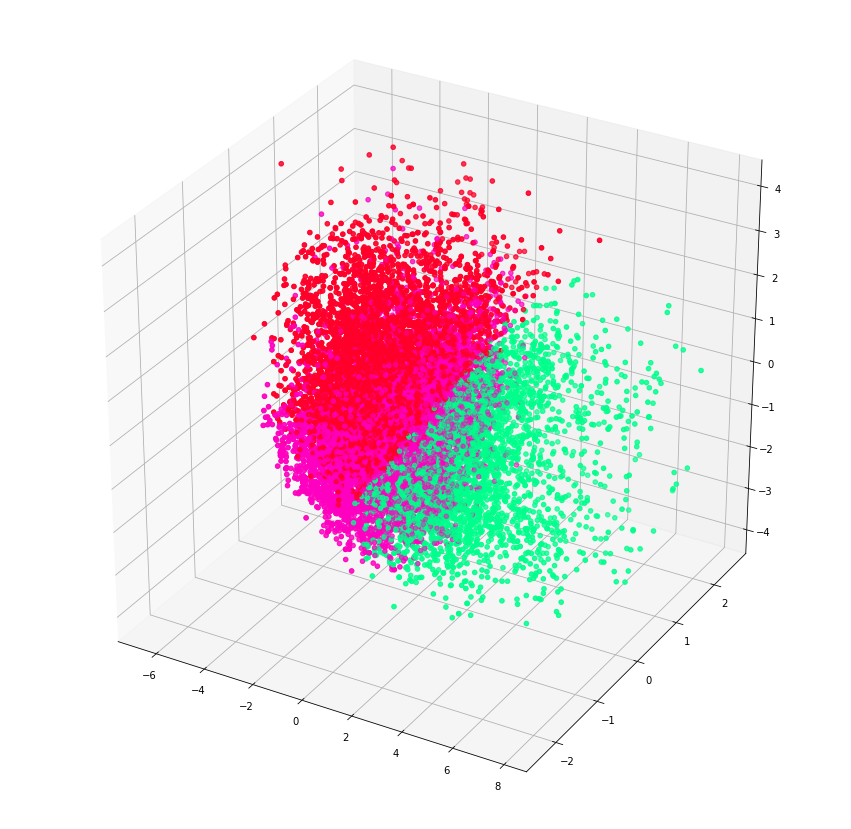

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (15,15))
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')
"""ax.set_xlim3d(-26, 27)
ax.set_ylim3d(-17, 25)
ax.set_zlim3d(-17, 10)"""
# Data for a three-dimensional line
zdata = df_info['ppg_pca1'].values
xdata = df_info['ppg_pca2'].values
ydata = df_info['ppg_pca3'].values
#index = np.random.randint(0,zdata.shape[0],X.shape[0])
ax.scatter3D(xdata, ydata, zdata, c=df_info['classes'].values ,cmap = 'gist_rainbow');


In [ ]:
for i in range(3):
  indexes = np.where(cluster_labels == i)[0]
  print("number of ppg signals in clusetr ",i,"is",len(indexes))
  print("indexes of first 10 elements are ",indexes[:9])


number of ppg signals in clusetr  0 is 9442
indexes of first 10 elements are  [ 1  2  5  8  9 11 12 13 14]
number of ppg signals in clusetr  1 is 6454
indexes of first 10 elements are  [ 0  3  4  6  7 10 16 18 19]
number of ppg signals in clusetr  2 is 12940
indexes of first 10 elements are  [ 79  80  81  82  83  86  91  95 110]


In [ ]:
X = X.reshape((X.shape[0],X.shape[1],1))
y = y.reshape((y.shape[0],y.shape[1],1))

In [ ]:
X.shape

(28836, 1024, 1)

In [ ]:
X_dic = {}
y_dic = {}
for i in range(3):
  X_dic[i] = X[np.where(cluster_labels == i)[0]]
  y_dic[i] = y[np.where(cluster_labels == i)[0]]

In [ ]:
X_dic[0].shape


(9442, 1024, 1)

In [ ]:
input_shape = (1024 , 1)

#Models building

##Encoder building 

In [ ]:
from keras.activations import relu

def encoder_builder(input):
  
  encoder = Conv1D(256,5,padding = 'same')(input)
  encoder = BatchNormalization()(encoder)
  encoder = LeakyReLU()(encoder)
  encoder = MaxPool1D(2,padding='same')(encoder)

  encoder = Conv1D(128,5,padding = 'same')(encoder)
  encoder = BatchNormalization()(encoder)
  encoder = LeakyReLU()(encoder)
  encoder = MaxPool1D(2,padding='same')(encoder)

  encoder = Conv1D(64,3,padding = 'same')(encoder)
  encoder = BatchNormalization()(encoder)
  encoder = LeakyReLU()(encoder)
  encoder = MaxPool1D(2,padding='same')(encoder)

  encoder = Conv1D(32,3,padding = 'same')(encoder)
  encoder = LeakyReLU()(encoder)
  encoder = MaxPool1D(2,padding='same')(encoder)

  encoder = LSTM(8,return_sequences = True,activation = 'relu')(encoder)
  encoder = MaxPool1D(2,padding='same')(encoder)

  encoder = Dropout(0.2)(encoder)
  encoder = Dense(32,activation = 'relu')(encoder)
  encoder = MaxPool1D(2,padding='same')(encoder)

  """ 

  encoder = Flatten()(encoder)
  encoder = Dense(16,activation = 'relu')(encoder)

  """

  return encoder


##Decoder building function

In [ ]:
def decoder_builder(input):
  decoder = Conv1D(256, 3, activation='relu', padding='same',name = 'decoder_input_layer')(input)
  decoder = UpSampling1D(2)(decoder)

  decoder = Conv1D(128, 3, activation='relu', padding='same')(decoder)
  decoder = UpSampling1D(2)(decoder)

  decoder = Conv1D(64, 5, activation='relu', padding='same')(decoder)
  decoder = UpSampling1D(2)(decoder)

  decoder = Conv1D(32, 5, activation='relu', padding='same')(decoder)
  decoder = UpSampling1D(2)(decoder)
  
  decoder = Conv1D(16, 3, activation='relu', padding='same')(decoder)
  decoder = UpSampling1D(2)(decoder)

  decoder = Conv1D(1, 3, activation='relu', padding='same')(decoder)
  decoder = UpSampling1D(2)(decoder)

#  decoder = Conv1D(256, 5, activation='relu', padding='same')(decoder)
  #decoder = UpSampling1D( 2)(decoder)
  decoder = Flatten()(decoder)
  decoder = Dense(1024, activation='relu',name = 'decoder_output_layer')(decoder)
  
  return decoder


## Models building

In [ ]:
inputs = tf.keras.layers.Input(shape=(1024,1))
encoder = encoder_builder(inputs)
encoder_model = keras.Model(inputs = inputs , outputs = encoder)

encoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 conv1d_9 (Conv1D)           (None, 1024, 256)         1536      
                                                                 
 batch_normalization_3 (Batc  (None, 1024, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024, 256)         0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 512, 256)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 512, 128)          1639

In [ ]:
decoder = decoder_builder(encoder)
decoder_model = keras.Model(inputs = encoder , outputs = decoder)
decoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16, 32)]          0         
                                                                 
 decoder_input_layer (Conv1D  (None, 16, 256)          24832     
 )                                                               
                                                                 
 up_sampling1d_6 (UpSampling  (None, 32, 256)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 32, 128)           98432     
                                                                 
 up_sampling1d_7 (UpSampling  (None, 64, 128)          0         
 1D)                                                             
                                                           

In [ ]:
autoencoder = keras.Model(inputs = inputs , outputs = decoder)
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 conv1d_9 (Conv1D)           (None, 1024, 256)         1536      
                                                                 
 batch_normalization_3 (Batc  (None, 1024, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024, 256)         0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 512, 256)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 512, 128)          1639

## callbacks, compiling and training

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
callbacks = [
            keras.callbacks.TensorBoard(
            log_dir='my_log_dir',
            histogram_freq=1,
            embeddings_freq=1,
            ),
             ModelCheckpoint('/content/gdrive/MyDrive/Master/traditional autoecoder',
                             save_best_only=True),
             keras.callbacks.EarlyStopping(
                                      monitor="val_loss",
                                      min_delta= 0,
                                      patience= 10,
                                      verbose= 0,
                                      mode="auto",
                                      baseline=None,
                                      restore_best_weights=True,
)
]

In [ ]:
autoencoder.compile(optimizer = 'adam',loss = 'mse',metrics = ['mse'])

In [ ]:
autoencoder.fit( X, y,epochs = 100 , batch_size = 32 , validation_split=0.1,callbacks=callbacks)

Epoch 1/100
811/811 [==============================] - ETA: 0s - loss: 0.1193 - mse: 0.1193

811/811 [==============================] - 137s 159ms/step - loss: 0.1193 - mse: 0.1193 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 2/100
811/811 [==============================] - ETA: 0s - loss: 0.0494 - mse: 0.0494

811/811 [==============================] - 87s 107ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 3/100
811/811 [==============================] - 74s 92ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0495 - val_mse: 0.0495
Epoch 4/100
811/811 [==============================] - ETA: 0s - loss: 0.0494 - mse: 0.0494

811/811 [==============================] - 78s 96ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 5/100
811/811 [==============================] - ETA: 0s - loss: 0.0493 - mse: 0.0493

811/811 [==============================] - 80s 98ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 6/100
811/811 [==============================] - 73s 90ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 7/100
811/811 [==============================] - 73s 90ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 8/100
632/811 [======================>.......] - ETA: 16s - loss: 0.0493 - mse: 0.0493

In [ ]:
autoencoder.evaluate(X[X.shape[0]-1000:],y[X.shape[0]-1000:])

32/32 [==============================] - 1s 17ms/step - loss: 0.0713 - mse: 0.0713


[0.07131612300872803, 0.07131612300872803]

In [ ]:
print("Output")
pred = autoencoder.predict(X[X.shape[0]-1000:])
k = X[X.shape[0]-1000:]

Output


In [ ]:
pred = pred.reshape((pred.shape[0],1,pred.shape[1]))

In [ ]:
pred.shape

(1000, 1, 1024)

In [ ]:
k.shape

(1000, 1024, 1)

'plt.figure\nplt.plot(k[1])'

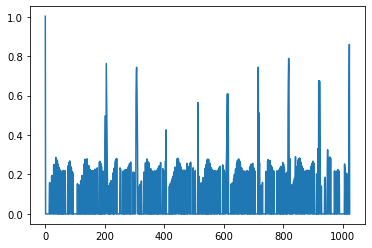

In [ ]:
plt.plot(pred[52,0,:])
"""plt.figure
plt.plot(k[1])"""

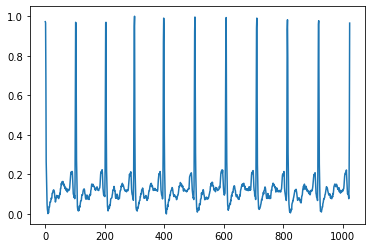

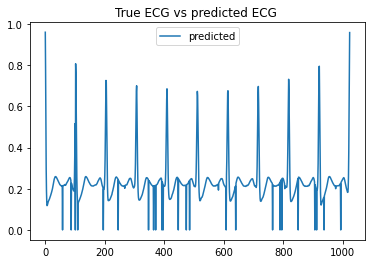

In [ ]:
i = np.random.randint(0,1000,1)[0]

plt.figure()
plt.plot(y[X.shape[0]-i,0,:],label = 'true')
plt.figure()

plt.plot(pred[i,0,:],label = 'predicted')
plt.title("True ECG vs predicted ECG ")
plt.legend()

In [ ]:
x = X[0,0,:]
x.shape


(1024,)

In [ ]:
x = np.array([[i]*50 for i in x]).T

In [ ]:
x

array([[0.95547, 0.95448, 0.94576, ..., 0.97403, 0.98997, 0.9954 ],
       [0.95547, 0.95448, 0.94576, ..., 0.97403, 0.98997, 0.9954 ],
       [0.95547, 0.95448, 0.94576, ..., 0.97403, 0.98997, 0.9954 ],
       ...,
       [0.95547, 0.95448, 0.94576, ..., 0.97403, 0.98997, 0.9954 ],
       [0.95547, 0.95448, 0.94576, ..., 0.97403, 0.98997, 0.9954 ],
       [0.95547, 0.95448, 0.94576, ..., 0.97403, 0.98997, 0.9954 ]])

In [ ]:
x.shape

(50, 1024)

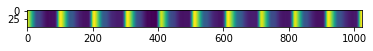

In [ ]:
plt.imshow(x)

In [ ]:
(x[0] == X[0,0,:]).sum()

1024

In [ ]:
model = keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/autoencoder")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1024, 256)         1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 512, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 512, 128)          163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 256, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 256, 64)           24640     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 128, 64)          0

In [ ]:
X = X.reshape((28836, 1024,1))

In [ ]:
pred = model.predict(X[:10,:,0])

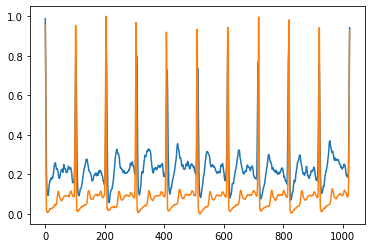

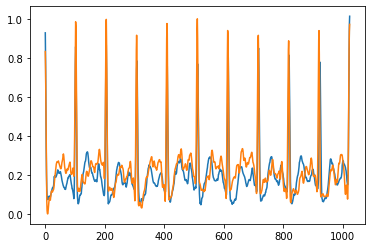

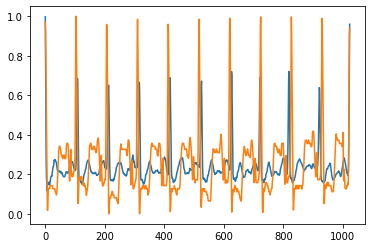

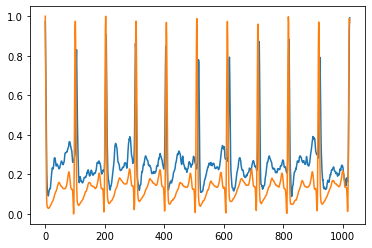

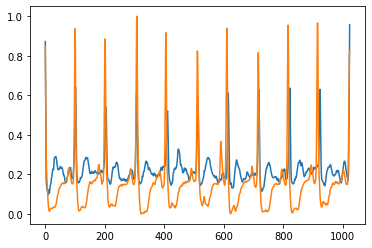

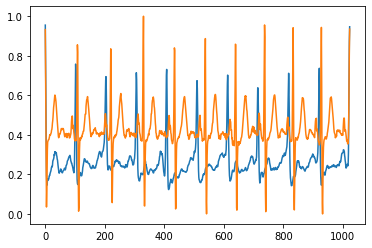

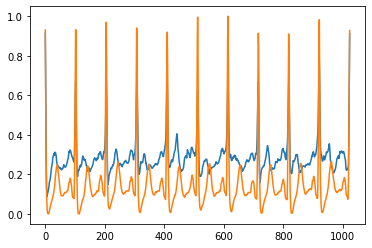

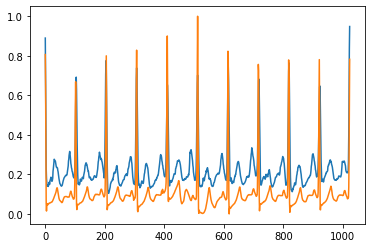

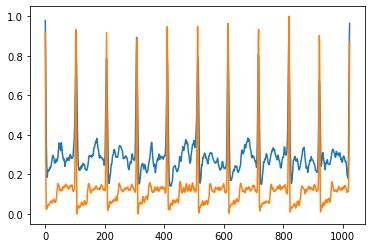

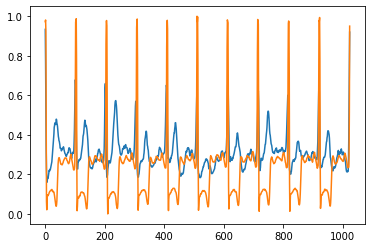

In [ ]:
for i in range(10):
  plt.figure()
  plt.plot(pred[i])
  plt.plot(y[i])